---

In [1]:
import numpy as np
import pandas as pd

from keras import regularizers, activations
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime 

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
USE_GOOGLE_COLAB = True

if USE_GOOGLE_COLAB:
    from google.colab import drive 
    drive.mount('/content/drive')

    # mevcut çalıştırma dizinini belirle
    %cd drive/'My Drive'/
else:
    %cd US8K

Mounted at /content/drive
/content/drive/My Drive


---

## 0. Data Frame Yükle <a name="zero-bullet"></a>

In [3]:
us8k_df = pd.read_pickle("/content/drive/MyDrive/DeepSound/us8k_df.pkl")

In [4]:
us8k_df.head()

,melspectrogram,label,fold
0,"[[-61.710167, -74.497375, -65.13373, -65.75191...",3,5
1,"[[-11.593307, -3.6112585, -12.501212, -13.6347...",2,5
2,"[[-24.203846, -14.91592, -6.091381, -12.995893...",2,5
3,"[[-15.059131, -12.813037, -12.300041, -11.4390...",2,5
4,"[[-9.877641, 0.0, -11.115211, -10.564412, -3.8...",2,5


---

## 1. Data aug. <a name="first-bullet"></a>

In [5]:
def init_data_aug():
    train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval=-80.0,
        width_shift_range=0.1,
        height_shift_range=0.0)

    val_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval=-80.0)
    
    return train_datagen, val_datagen

---

## 2. CNN model  <a name="second-bullet"></a>


In [6]:
def init_model():
    model1 = Sequential()
    
    
    model1.add(Conv2D(filters=24, kernel_size=5, input_shape=(128, 128, 1),
                      kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(3,3), strides=3))
    model1.add(Activation(activations.relu))
    
    
    model1.add(Conv2D(filters=36, kernel_size=4, padding='valid', kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(Conv2D(filters=36, kernel_size=4, padding='valid', kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model1.add(Activation(activations.sigmoid))
    
    
    model1.add(Conv2D(filters=48, kernel_size=3, padding='valid'))
    model1.add(Conv2D(filters=48, kernel_size=3, padding='valid'))
    model1.add(Activation(activations.linear))
    
    model1.add(GlobalAveragePooling2D())
    
    
    model1.add(Dense(60, activation='relu'))
    model1.add(Dropout(0.5))
    
    
    model1.add(Dense(10, activation='softmax'))

    
    
    model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')
    
    return model1

In [7]:
model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 24)      624       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 24)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 41, 41, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 36)        13860     
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 36)        20772     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 36)       0         
 2D)                                                    

---

fonk

In [8]:
def train_test_split(fold_k, data, X_dim=(128, 128, 1)):
    X_train = np.stack(data[data.fold != fold_k].melspectrogram.to_numpy())
    X_test = np.stack(data[data.fold == fold_k].melspectrogram.to_numpy())

    y_train = data[data.fold != fold_k].label.to_numpy()
    y_test = data[data.fold == fold_k].label.to_numpy()

    XX_train = X_train.reshape(X_train.shape[0], *X_dim)
    XX_test = X_test.reshape(X_test.shape[0], *X_dim)
    
    yy_train = to_categorical(y_train)
    yy_test = to_categorical(y_test)
    
    return XX_train, XX_test, yy_train, yy_test

In [9]:
def process_fold(fold_k, data, epochs=100, num_batch_size=32):
    
    X_train, X_test, y_train, y_test = train_test_split(fold_k, data)

    
    train_datagen, val_datagen = init_data_aug()
    
    
    train_datagen.fit(X_train)
    val_datagen.fit(X_train)

    
    model = init_model()

    
    score = model.evaluate(val_datagen.flow(X_test, y_test, batch_size=num_batch_size), verbose=0)
    print("Pre-training accuracy: %.4f%%\n" % (100 * score[1]))
    
    
    start = datetime.now()
    history = model.fit(train_datagen.flow(X_train, y_train, batch_size=num_batch_size), 
                        steps_per_epoch=len(X_train) / num_batch_size, 
                        epochs=epochs, 
                        validation_data=val_datagen.flow(X_test, y_test, batch_size=num_batch_size))
    end = datetime.now()
    print("Training completed in time: ", end - start, '\n')
    
    return history

In [10]:
def show_results(tot_history):
    

    for i, history in enumerate(tot_history):
        print('\n({})'.format(i+1))

        plt.figure(figsize=(15,5))

        plt.subplot(121)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.grid(linestyle='--')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(122)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.grid(linestyle='--')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')
            
        plt.show()

        print('\tMax validation accuracy: %.4f %%' % (np.max(history.history['val_accuracy']) * 100))
        print('\tMin validation loss: %.5f' % np.min(history.history['val_loss']))

---

### fold-1 <a name="fold-1"></a>

In [11]:
FOLD_K = 1
REPEAT = 1

history1 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=5)
    history1.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 13.7457%

Epoch 1/5
245/245 [==============================] - 163s 659ms/step - loss: 2.2654 - accuracy: 0.1772 - val_loss: 2.0947 - val_accuracy: 0.2864
Epoch 2/5
245/245 [==============================] - 166s 677ms/step - loss: 2.1580 - accuracy: 0.2139 - val_loss: 2.0111 - val_accuracy: 0.2910
Epoch 3/5
245/245 [==============================] - 162s 659ms/step - loss: 2.1081 - accuracy: 0.2290 - val_loss: 1.9663 - val_accuracy: 0.2875
Epoch 4/5
245/245 [==============================] - 161s 656ms/step - loss: 2.0646 - accuracy: 0.2414 - val_loss: 1.9435 - val_accuracy: 0.2612
Epoch 5/5
245/245 [==============================] - 164s 666ms/step - loss: 2.0453 - accuracy: 0.2410 - val_loss: 1.9290 - val_accuracy: 0.2921
Training completed in time:  0:14:56.581908 




(1)


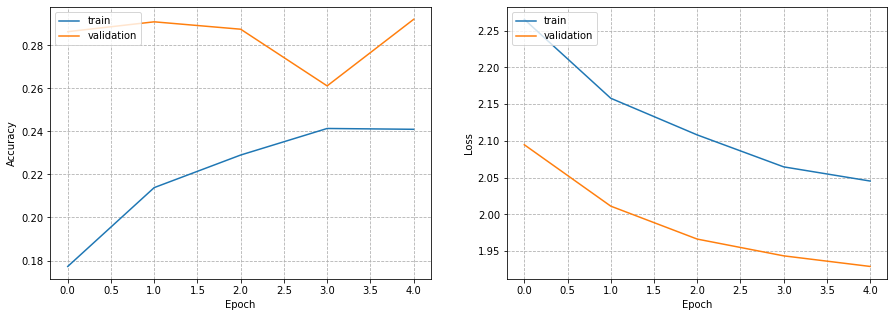

	Max validation accuracy: 29.2096 %
	Min validation loss: 1.92905


In [12]:
show_results(history1)